# IV & Average Causal Response
In the first part of this notebook we reproduce IV/Average Causal Response results for the Quarter of Birth-data presented in *MHE* (e.g. Table 4.1.1 p.124). According to II. Theorem 4.5.3 the Wald estimator can be written as a weighted sum with explicit weights (see  II. Theorem 4.5.3.), which we reproduce as well. These formulas are presented in *MHE*. However, the summands themselves seem to be inaccessible.

In the second part of the notebook, we try to apply the methods developed in Angrist/Abadie/Imbens *Instrumental Variables Estimates of The Effect of Subsidized Training on the Quantiles of Trainee Earnings* to obtain estimates of these contributions.

The settings of the ACR theorem is the following. We assume a model $Z\rightarrow S\rightarrow Y$ with binary $Z$, discrete $S$ and continuous $Y$, and write $S = Z\cdot S_1+(1-Z)\cdot S_0$ and $Y = \sum_{s\geq 0}(Y_s-Y_{s-1})\cdot (S\geq s)$, $Y_{-1}=0$.

The ACR theorem (*MHE Theorem 4.5.3*) states the following.


Given the assumptions 
> - ACR1: $\{Y_s, S\}$ are jointly independet of Z given $X$.
> - ACR2: $E[S_1-S_0]\neq 0$,
> - ACR3: $S_1\geq S_0$ almost surely.

the Wald estimator is a weighted sum:

> $ \frac{E[Y|Z=1]-E[Y|Z=0]}{E[S|Z=1]-E[S|Z=0]} = \sum_s \omega_s E[Y_{s}-Y_{s-1}|S_1\geq s >S_0],\ \ \omega_s = P(S_1\geq s>S_0)/\sum_t  P(S_1\geq t>S_0)$,

and the weights can be computed explicitely:
> $P(S_1>=s>S_0) = P(S<s|Z=0)-P(S<s|Z=1)$.


In contrast, for the individual summands in the ACR-formula  -$E[Y_s-Y_{s-1}|S_1\geq s>S_0]$ -
this seems to be not true. We are interested in using Abadie's $\kappa$-Theorem (*MHE Theorem 4.5.2*) to estimate these.

Declaring $D(t) = (S>=t)$ we claim that $D(t)$ satisfies the conditions ACR 1-3.

  - D1: $\{Y_s, D(t)\}$ are jointly independent of $Z$ given $X$.
  - D2: $E[D(t)_1-D(t)_0|X]\ne 0$
  - D3: $D(t)_1>=D(t)_0$ almost surely.

D1 follows directly from the ACR1 and D3 is equivalent to ACR3.

For D2:

$E[D(t)_1-D(t)_0|X]\\
= P(S\geq t|Z=1, X) - P(S\geq t|Z=0, X)\\ 
= -P(S<t|Z=1, X) + P(S<t|Z=0, X)\\
= P(S_{1}\geq t>S_0|X)>0$

The significance of $D(t)$ comes from the fact that the complier condition $D(t)_1>D(t)_0$ is actually equivalent to $S_1\geq s>S_0$. Hence, the $D(t)$-compliers give the different summands in the ACR theorem.

Using $D1-D3$, we conclude from Abadie/Angrist/Imbens Lemma 2.1 that the treatment status $D(t)$ is independent of potential outcomes $\{Y_s\}$ given X and $D(t)_1>D(t)_0$ so that

$E[Y|D(t)_1>D(t)_0, D(t)=d] \\
= E[Y_{S_d}|D(t)_1>D(t)_0, D(t)=d]\\
= E[Y_{S_d}|D(t)_1>D(t)_0]$.

The complieres can be found by means of the
$\kappa$-function and hence a weighted regression allows for a causal interpretation
of the coefficient of $D(t)$:

>With $\kappa_t = 1- (1-D(t))Z/P(Z) - D(t)(1-Z)/(1-P(Z))$ and
>$\alpha, \beta = argmin(\kappa_t \cdot |Y-aD(t) -X'b|^2)$,
>
>we have $\alpha\sim E[Y_{S_1}-Y_{S_0}|D(t)_1>D(t)_0]$.

An estimation strategy is discussed in  MHE.
However, the result is not precisely what we are after - $E[Y_{t}-Y_{t-1}|D(t)_1>D(t)_0]$.

So instead, instead we use different matching strategies to compute estimated effects through $(Y_1-Y_0)/(S_1-S_0)$. Though non-obvious, we argue that those do capture something about the data.

Remark:
- We find that the estimation is a subtle issue. For instance, in the case of the simulated data we get better results when working with $E[Z|Y,X,S=s]$ instead of $E[Z|Y,X,D(t)]$.

- Theoretically, the modified version $\kappa_{t,t+1} = 1- (1-D(t))Z/P(Z) - D(t+1)(1-Z)/(1-P(Z))$ yields a weight for the intersection of $D(t)_1>D(t)_0$ and $D(t+1)_1>D(t+1)_0$, i.e. $S_1>=t+1>t>S_0$. Hence, potentially one could use this to calculate contributions of slices $S_1=t>S_0$, $S_1>t=S_0$.



For verification, with the flag *SIM* simulated data can be used instead of the original data.

In [1]:
#SIM=True
SIM=False

## 0) Imports & Convenience Functions

In [2]:
from IPython.display import clear_output
import os
import pandas
import numpy
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Probit
from linearmodels import IV2SLS
import requests

## 1)  Load Dataset

In [3]:
def get_sim():
    N = 300000
    df_gen = pandas.DataFrame({"yob": numpy.random.randint(1, 11,N) , 
                               "qob": numpy.random.randint(0,2, N), 
                               "pob": numpy.random.randint(1,6, N)})

    df_gen["qob"] = df_gen["qob"] * 3 +1 
    
    abi =  numpy.random.normal(10,5, N)
    df_gen["educ"] = abi#(abi==0)*numpy.random.normal(9,1 , N) + (abi==1)*numpy.random.normal(10,1 , N) + (abi==2)*numpy.random.normal(11,1 , N) 
    
    df_gen["educ"] = df_gen["educ"].astype("int")
    df_gen["educ"] += (df_gen["educ"].astype("int").isin([5,6,7,8,9,10,11,12,13]))*(df_gen["qob"]==4)*numpy.random.randint(1,5, N)
    df_gen["educ"] = df_gen["educ"].astype("int").clip(6,18)
    df_gen["lwklywge"] = df_gen["educ"]*.15 +  (abi)*.15 + numpy.random.normal(0,1, N)
    df_gen["lwklywge"] = (df_gen["lwklywge"].clip(0,20)+.1)
    
    return df_gen

In [4]:
if SIM:
    df = get_sim()
else:
    url = "https://economics.mit.edu/sites/default/files/publications/asciiqob.zip"
    u = requests.get(url)
    raw_zip = u.content

    tmp_f = "tmp.zip"
    with open("tmp.zip", "wb") as f:
        f.write(raw_zip)

    df = pandas.read_csv(tmp_f, sep="        ", header=None )
    os.remove(tmp_f)
    df.columns = ['lwklywge', 'educ', 'yob', 'qob', 'pob']


for qob in sorted(df["qob"].unique()):
    df[f"qob_{qob}"] = (df["qob"]==qob)*1.0
for yob in sorted(df["yob"].unique()):
    df[f"yob_{yob}"] = (df["yob"]==yob)*1.0
for pob in sorted(df["pob"].unique()):
    df[f"pob_{pob}"] = (df["pob"]==pob)*1.0

#pob_dummies

cols = ["const", "educ"]
yob_dummies = [c for c in df.columns if "yob_" in c]
pob_dummies = [c for c in df.columns if "pob_" in c]
qob_dummies = [c for c in df.columns if "qob_" in c]

additional_cov = ["const"]
#additional_cov +=yob_dummies
#additional_cov +=pob_dummies
#additional_cov +=yob_dummies

df["const"] = 1

df= df[df["qob"].isin([1,2,3,4])]
df.head()

/data/user/0/ru.iiec.pydroid3/files/aarch64-linux-android/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,lwklywge,educ,yob,qob,pob,qob_1,qob_2,qob_3,qob_4,yob_30,...,pob_47,pob_48,pob_49,pob_50,pob_51,pob_53,pob_54,pob_55,pob_56,const
0,5.790019,12,30,1,45,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,5.952494,11,30,1,45,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,5.315949,12,30,1,45,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,5.595926,12,30,1,45,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,6.068915,12,30,1,37,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


## 2) OLS and IV

Here we reproduce the OLS and IV estimates of the return of schooling of .071 resp .10 respectively.

In [5]:
# Cf. MHE Table 4.1.1 (p. 124) --> OLS (2)

endog=df[["lwklywge"]] 
exog=df[["educ"]+additional_cov]
mod = sm.OLS(endog=endog, exog=exog, check_rank=False)
res = mod.fit()
res.summary()

/data/user/0/ru.iiec.pydroid3/files/aarch64-linux-android/lib/python3.9/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['check_rank']
  warnings.warn(msg, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               lwklywge   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                 4.378e+04
Date:                Fri, 28 Jul 2023   Prob (F-statistic):               0.00
Time:                        06:50:18   Log-Likelihood:            -3.1935e+05
No. Observations:              329509   AIC:                         6.387e+05
Df Residuals:                  329507   BIC:                         6.387e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
educ           0.0709      0.000    209.243      0.000       0.070       0.072
const          4.9952      0.004   1118.882      0.000       4.986       5.004
==============================================================================
Omnibus:                   191064.440   Durbin-Watson:                   1.870
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4082110.366
Skew:                          -2.377   Prob(JB):                         0.00
Kurtosis:                      19.575   Cond. No.                         53.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [6]:
from linearmodels import IV2SLS, IVGMM, IVGMMCUE, IVLIML
df["Z"] = df["qob"].isin([3,4])

dependent =df[["lwklywge"]] 
endog= df["educ"]

ivmod = IV2SLS(dependent=dependent, exog=df[additional_cov], endog = endog, instruments=df["Z"])
res_2sls = ivmod.fit()
res_2sls.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:               lwklywge   R-squared:                      0.0750
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0750
No. Observations:              329509   F-statistic:                    27.737
Date:                Fri, Jul 28 2023   P-value (F-stat)                0.0000
Time:                        06:50:19   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          4.4519     0.2750     16.191     0.0000      3.9130      4.9908
educ           0.1134     0.0215     5.2666     0.0000      0.0712      0.1556
==============================================================================

Endogenous: educ
Instruments: Z
Robust Covariance (Heteroskedastic)
Debiased: False
"""

## 3) ACR


### ACR Weights



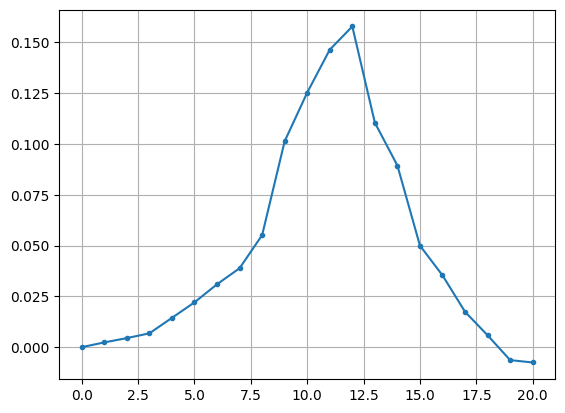

In [7]:
Z = df["qob"].isin([3,4])

denominator = df[~Z]["educ"].mean() - df[Z]["educ"].mean()

numerators = []
for s in df["educ"].unique():
    
    numerator = -(df[Z]["educ"]<s).sum()/Z.sum()+(df[~Z]["educ"]<s).sum()/(~Z).sum()
    numerators.append({"s": s, "omega": -numerator/(1)})
    
    
df_omega = pandas.DataFrame(numerators).sort_values("s")

df_omega["omega"] = df_omega["omega"]/df_omega["omega"].sum()

%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(df_omega["s"], df_omega["omega"], marker=".")
plt.grid()
plt.show()


### ACR summands


In [ ]:
import os
import pandas
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Probit
from linearmodels import IV2SLS
from sklearn.linear_model import QuantileRegressor, LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_validate
import numpy
from sklearn.ensemble import RandomForestClassifier

@property
def params(self):
    return pandas.Series(data = self.coef_, index=self.feature_names_in_)
QuantileRegressor.params = params

class ProbitWrapper:
    """Provides sklearn API for statsmodels Probit"""
        
    def __init__(self):
        pass
    
    def fit(self, X, y):
        self.model = Probit(y, X)
        self.res = self.model.fit(max_iter=200, method= "newton")
    
    def predict_proba(self, X):
        p1 = self.res.predict(X)
        p0 = 1-p1
        return pandas.concat([p0, p1], axis=1).values
    
    def predict(self,X):
        return self.res.predict(X)
    
    def get_params(self, deep=False):
        return {}
    @property
    def classes_(self):
        return numpy.array([0,1])
    
RF_KWARGS_DEF = {
    "n_estimators": 100, 
    "criterion":'gini',
    "max_depth":None,
    "min_samples_split":2,
    "min_samples_leaf":1,
    "min_weight_fraction_leaf":0.0,
    "max_features":'auto',
    "max_leaf_nodes":None,
    "min_impurity_decrease":0.0,
    "bootstrap":True,
    "oob_score":False,
    "n_jobs":None,
    "random_state":None,
    "verbose":0,
    "warm_start":False,
    "class_weight":None,
}

RF_KWARGS_MAX = {k:v for k,v in RF_KWARGS_DEF.items()}
RF_KWARGS_MAX["max_depth"] = 10000
RF_KWARGS_MAX["bootstrap"] = False

RF_KWARGS_1 = {k:v for k,v in RF_KWARGS_DEF.items()}
RF_KWARGS_1["max_depth"] = 4
RF_KWARGS_1["min_samples_split"] = 10
RF_KWARGS_1["min_samples_leaf"] = 10
RF_KWARGS_1["oob_score"] = True
RF_KWARGS_1["max_samples"] = .7

RF_KWARGS_2 = {k:v for k,v in RF_KWARGS_DEF.items()}
RF_KWARGS_2["max_depth"] = 8
RF_KWARGS_2["min_samples_split"] = 5
RF_KWARGS_2["min_samples_leaf"] = 5
RF_KWARGS_2["oob_score"] = True
RF_KWARGS_2["max_samples"] = .7

RF_KWARGS_3 = {k:v for k,v in RF_KWARGS_DEF.items()}
RF_KWARGS_3["max_depth"] = 16
RF_KWARGS_3["min_samples_split"] = 5
RF_KWARGS_3["min_samples_leaf"] = 5
RF_KWARGS_3["max_samples"] = .7
RF_KWARGS_3["oob_score"] = True

RF_KWARGS_4 = {k:v for k,v in RF_KWARGS_DEF.items()}
RF_KWARGS_4["max_depth"] = 16
RF_KWARGS_4["min_samples_split"] = 3
RF_KWARGS_4["min_samples_leaf"] = 3
RF_KWARGS_4["max_samples"] = .7
RF_KWARGS_4["oob_score"] = True

In [ ]:
from sklearn.linear_model import LinearRegression

def fit_model(model_name, model_kwargs, X, y):
    modelname2model = {"probit": ProbitWrapper, 
                       "rf": RandomForestClassifier, 
                       "logit": LogisticRegression,
                       "logitcv": LogisticRegressionCV,                       
                        "linear": LinearRegression
                      }
    Model = modelname2model[model_name]
    model = Model(**model_kwargs)
    model.fit(y=y, X=X)
    if model_name in ["probit", "rf", "logit", "logitcv"]:
        pred = model.predict_proba(X)[:,1]
        pred = pandas.Series(pred, X.index)
        cv = -cross_validate(model, X, y, cv=2, scoring="roc_auc")["test_score"]
                
    elif model_name in ["linear"]:
        pred = model.predict(X)
        pred = pandas.Series(pred, X.index)
        cv = cross_validate(model, X, y, cv=2, scoring="neg_mean_squared_error")["test_score"]
    return pred, cv

def get_p_z_cond(xs, ys, zs, ds, model_name, kwargs, sep_d=True):
    p_z_given_y_x_d0 = 0*ds + 1000*0
    p_z_given_y_x_d1 = 0*ds + 1000*0
    p_z_given_y_x_d = 0*ds+1000*0

    p_z_given_x = 0*ds + 1000*0
    all_pred =[]
    all_cv = []
    deg = kwargs["deg"]
    model_kwargs = kwargs["model_kwargs"]
    if sep_d:
        for d in [0,1]:
            m_d = ds==d
            y, X = zs[m_d], pandas.concat([xs[m_d]] + [ys[m_d]**k for k in range(1, deg+1)], axis=1)

            if y.nunique()==1:
                pred, cv = y, numpy.array([0])
            else:
                pred, cv = fit_model(model_name, model_kwargs, X, y)
            all_pred.append(pred[m_d])

            if d==0:
                p_z_given_y_x_d0.loc[m_d] = pred[m_d]
                cv0 = numpy.mean(-cv)
            elif d==1:
                p_z_given_y_x_d1.loc[m_d] = pred[m_d]
                cv1 = numpy.mean(-cv)
            else:
                raise AssertionError("")
    else:
        #y, X = zs, pandas.concat([xs]  + [ys**k for k in range(1, deg+1)], axis=1)
        #y, X = zs, pandas.concat([xs] + [ds] + [ys*ds] + [ys**k for k in range(1, deg+1)], axis=1)
        y, X = zs, pandas.concat([xs] + [ds] + [ys**k for k in range(1, deg+1)], axis=1)
        X.columns = list(range(len(X.columns)))
        
        if y.nunique()==1:
            pred, cv = y, numpy.array([0])
        else:
            pred, cv = fit_model(model_name, model_kwargs, X, y)

        all_pred.append(pred)
        m_d = ds==0
        p_z_given_y_x_d0.loc[m_d] = pred[m_d]
        cv0 = numpy.mean(-cv)
        m_d = ds==1
        p_z_given_y_x_d1.loc[m_d] = pred[m_d]
        cv1 = numpy.mean(-cv)
        p_z_given_y_x_d = pred
        
    y, X = zs, xs
    X = X[list(X.columns)[0:1]]*0+1 # comment in paper
    pred, cv = fit_model(model_name, model_kwargs, X, y)
    all_pred.append(pred)
    cv2 = cv
    p_z_given_x = pred
    
    return p_z_given_y_x_d0, p_z_given_y_x_d1, p_z_given_x, cv0, cv1, cv2, p_z_given_y_x_d

    

In [ ]:
from sklearn.linear_model import LassoCV

#X = df[additional_cov+yob_dummies[:]+pob_dummies[:]+ qob_dummies]
X = df[additional_cov+yob_dummies[:]+pob_dummies[:]]

y = df["educ"]

lassocv = LassoCV(fit_intercept=False, positive=False)
lassocv.fit(X,y)
selected_cov_1 = [x for x,c in zip(X.columns, lassocv.coef_) if c !=0]
m_ = sm.OLS(y, X[selected_cov_1])
res = m_.fit()
selected_cov_1 = [x for x,x_p in res.pvalues.to_dict().items() if x_p<.01]

y = df["lwklywge"]
lassocv = LassoCV(fit_intercept=False, positive=False)
lassocv.fit(X,y)
selected_cov_2 = [x for x,c in zip(X.columns, lassocv.coef_) if c !=0]
m_ = sm.OLS(y, X[selected_cov_2])
res = m_.fit()
selected_cov_2 = [x for x,x_p in res.pvalues.to_dict().items() if x_p<.01]


In [ ]:
selected_cov = list(set(selected_cov_1)|set(selected_cov_2))
#selected_cov = list(set(selected_cov_1)&set(selected_cov_2))
selected_cov = [c for c in selected_cov if any(kw in c for kw in ["const", "yob_", "pob_"])]
#selected_cov = ["const"]
len(selected_cov), selected_cov

In [ ]:
#settings to fit kappa
sep_d=True
model_name, model_kwargs =  "logit", {"deg": 2, 
                                      "model_kwargs": {"solver":"liblinear", 
                                                       "fit_intercept": False, 
                                                       "max_iter":500}}
indiv_d = False

In [ ]:
from scipy.stats import yeojohnson, boxcox
all_res = []
from tqdm import tqdm
for i in tqdm(range(1)):
    print(f"Trial {i}")
    #df_ = df.sample(n=len(df), replace=True).copy().reset_index(drop=True)
    df_ = df
    #df_ = df
    xs = df_[selected_cov]
 
    ys, _ = boxcox(df_["lwklywge"].clip(2, 20))
    ys = pandas.Series(ys, df_.index)
    ys = (ys-ys.mean())/ys.std()
    ys.name = "lwklywge"

    zs = df_["qob"].isin([3,4])*1
    t_range = sorted(df["educ"].unique())[1:-1]
    #t_range = [10, 11,12,13]
    
    print(f"Calc kappa_t step 1: conditional expectations of z")
    for t in t_range:    
        if indiv_d:
            ds = abs(df_["educ"]-t)<=1

        else:
            ds = (df_["educ"]>=t)*1
        
        p_z_given_y_x_d0, p_z_given_y_x_d1, p_z_given_x, cv0, cv1, cv2, p_z_given_y_x_d = get_p_z_cond(xs, ys, zs, ds, model_name, model_kwargs, sep_d=sep_d)
    
        df_[f"p_z_given_y_x_d{t}_0"] = p_z_given_y_x_d0
        df_[f"p_z_given_y_x_d{t}_1"] = p_z_given_y_x_d1
        df_[f"p_z_given_y_x_d"] = p_z_given_y_x_d
        df_[f"p_z_given_x"] = p_z_given_x
        print({"i":  i, "t": t, "cv0": cv0, "cv1": cv1})
        
    print(f"Calc kappa_t step 2: actual calculation")

    for t in t_range:
        REG = .001

        if not indiv_d:
            df_[f"kappa_{t}"] = 1
            df_[f"kappa_{t}"] -= (df_["educ"]>=t)*((1-df_[f"p_z_given_y_x_d{t}_1"]+REG)/(REG+1-df_[f"p_z_given_x"]) )
            df_[f"kappa_{t}"] -= (df_["educ"]<t)*( (df_[f"p_z_given_y_x_d{t}_0"]+REG)/(REG+df_[f"p_z_given_x"]))
        else:
            S1 = 0
            S2 = 0
            for i in range(0,20):
                if f"p_z_given_y_x_d{t+i}_1" in df_.columns:
                    S1_= (df_["educ"]==t+i)*(1-df_[f"p_z_given_y_x_d{t+i}_1"]+REG)/(REG+1-df_["p_z_given_x"])
                    S1+=S1_
                if f"p_z_given_y_x_d{t-i-1}_1" in df_.columns:
                    S2_= (df_["educ"]==t-i-1)*(df_[f"p_z_given_y_x_d{t-i-1}_1"]+REG)/(REG+df_["p_z_given_x"])
                    S2+=S2_
            df_[f"kappa_{t}"] = 1-S1-S2
        
        df_[f"kappa_{t}"] = df_[f"kappa_{t}"].clip(0,1)
        df_[f"kappa_{t}"] = df_[f"kappa_{t}"].fillna(df_[f"kappa_{t}"].median())
        
        
    print(f"Calculate Estimator")

    X = df_[selected_cov + ["educ"]]
    y = df_["lwklywge"]

    for do_shuffle in [False, True]:
        for t in t_range:
            print("... at t", t)
            df_["d"] = (df_["educ"]>=t)*1
            df_["Z"] = df_["qob"].isin([3,4])*1

            #m_ = sm.OLS(df_["d"], df_["Z"])
            m_ = sm.OLS(df_[["d"]], df_[["Z", "const"]])

            res = m_.fit()
            f_firststage = res.fvalue
            sample_weight = df_[f"kappa_{t}"]**1 

            sample_weight = sample_weight*(df_["d"]==df_["Z"])

            #random samples for check...
            if do_shuffle:
                sample_weight_v = sample_weight.sample(n=len(sample_weight), replace=True)
                sample_weight = pandas.Series(sample_weight_v.values, index=sample_weight.index)

            #lr = LinearRegression(fit_intercept=False)
            #lr.fit(X, y, sample_weight=  sample_weight)
            #params = {f"{k}_{t}":v for k,v in zip(X.columns, lr.coef_, ) if "educ" in k}

            Z = df_["Z"]==1.0
            omega_t = (df_[Z]["educ"]>=t).sum()/Z.sum()-(df_[~Z]["educ"]>=t).sum()/(~Z).sum()

            m_0 = (sample_weight>0)&(df_["d"]==0)
            m_1 = (sample_weight>0)&(df_["d"]==1)
            if m_0.sum()==0 or m_1.sum()==0:
                continue
            df_["sample_weight"] = sample_weight

            X = df_[selected_cov]
            y = df_["lwklywge"]
            lr = LinearRegression()
            lr.fit(X, y)
            y0_0 = lr.predict(df_[selected_cov])
            df_["lwklywge_0"]= y0_0

            X = df_[selected_cov]
            y = df_["educ"]
            lr = LinearRegression()
            lr.fit(X, y)
            y0_0 = lr.predict(df_[selected_cov])
            df_["educ_0"]= y0_0

            df_0 = df_[m_0][["lwklywge", "educ", "sample_weight"]+selected_cov + ["educ_0", "lwklywge_0"]].copy()
            df_1 = df_[m_1][["lwklywge", "educ", f"sample_weight"]+selected_cov + ["educ_0", "lwklywge_0"]].copy()

            #X = df_0[selected_cov]
            #y = df_0["lwklywge"]
            #lr = LinearRegression()
            #lr.fit(X, y)
            #y0_0 = lr.predict(df_0[selected_cov])
            #df_0["lwklywge_0"]= y0_0

            #y0_0 = lr.predict(df_1[selected_cov])
            #df_1["lwklywge_0"]= y0_0

            #X = df_0[selected_cov]
            #y = df_0["educ"]
            #lr = LinearRegression()
            #lr.fit(X, y)
            #y0_0 = lr.predict(df_0[selected_cov])
            #df_0["educ_0"]= y0_0

            #y0_0 = lr.predict(df_1[selected_cov])
            #df_1["educ_0"]= y0_0

            df_0 = df_0[["lwklywge", "educ", f"sample_weight", "lwklywge_0", "educ_0"]]
            df_1 = df_1[["lwklywge", "educ", f"sample_weight", "lwklywge_0", "educ_0"]]
            #df_0.mean(), df_1.mean()
            #df_0
            #df_0.groupby(["educ"], as_index=False).mean()
            alphas_0 = []
            alphas_1 = []
            alphas_2 = []
            alphas_3 = []

            for _ in range(100):
                df_0_ = df_0.sample(n=500, replace=True, random_state=_)
                df_1_ = df_1.sample(n=500, replace=True, random_state=_)

                df_cross = df_0_.merge(df_1_, how="cross", suffixes=("_0", "_1"))
                #cov_0 = [f"{c}_0" for c in selected_cov]
                #cov_1 = [f"{c}_1" for c in selected_cov]
                #df_cov_0 = df_cross[cov_0].rename(columns={c:c[:-2] for c in cov_0})
                #df_cov_1 = df_cross[cov_1].rename(columns={c:c[:-2] for c in cov_1})

                #d_cov = abs(df_cov_0-df_cov_1).sum(axis=1)+1
                #df_cross["cov_d"] = d_cov

                #df_cross["alpha_0"] = (df_cross["lwklywge_1"]-df_cross["lwklywge_0"])
                #df_cross["alpha_0"] /= (df_cross["educ_1"]-df_cross["educ_0"])

                dlwklywge = (df_cross["lwklywge_1"]-df_cross["lwklywge_0"])
                dlwklywge_0 = (df_cross["lwklywge_0_1"]-df_cross["lwklywge_0_0"])
                deduc = (df_cross["educ_1"]-df_cross["educ_0"])
                deduc_0 = (df_cross["educ_0_1"]-df_cross["educ_0_0"])

                weight = df_cross[f"sample_weight_0"]*df_cross[f"sample_weight_1"]
                matching_weight = weight * 1/(deduc_0+1)

                a_0 = (dlwklywge/deduc*weight).sum()/weight.sum()
                a_1 = (((dlwklywge-dlwklywge_0)/(deduc-deduc_0))*weight).sum()/weight.sum()

                a_2 = (dlwklywge/deduc*matching_weight).sum()/matching_weight.sum()
                a_3 = (((dlwklywge-dlwklywge_0)/(deduc-deduc_0))*matching_weight).sum()/matching_weight.sum()

                #df_cross["dlwklywge"] = (df_cross["lwklywge_1"]-df_cross["lwklywge_0_1"]-df_cross["lwklywge_0"]+df_cross["lwklywge_0_0"])
                #df_cross["deduc"] = (df_cross["educ_1"]-df_cross["educ_0_1"]-df_cross["educ_0"]+df_cross["educ_0_0"])        
                #df_cross["alpha"] = df_cross["dlwklywge"]/df_cross["deduc"]

                #a_0 = (df_cross["alpha_0"]*df_cross[f"sample_weight_0"]*df_cross[f"sample_weight_1"]).sum()
                #a_0 /= (df_cross[f"sample_weight_0"]*df_cross[f"sample_weight_1"]).sum()

                #a_ = (df_cross["alpha"]*df_cross[f"sample_weight_0"]*df_cross[f"sample_weight_1"]).sum()
                #a_ /= (df_cross[f"sample_weight_0"]*df_cross[f"sample_weight_1"]).sum()


                #all_res.append({"t":t, "a_0": a_0, "a":a_, "b":b_, "c":c_})
                #alphas.append(a_)
                #alphas_0.append(a_0)
                alphas_0.append(a_0)
                alphas_1.append(a_1)
                alphas_2.append(a_2)
                alphas_3.append(a_3)

            alpha_0 = numpy.median(alphas_0)
            alpha_1 = numpy.median(alphas_1)
            alpha_2 = numpy.median(alphas_2)
            alpha_3 = numpy.median(alphas_3)

            res = {"shuffle": do_shuffle, "i":i, "t": t,"f":f_firststage, "omega": omega_t, 
                   "alpha_0": alpha_0, 
                   "alpha_1": alpha_1,
                   "alpha_2": alpha_2,
                   "alpha_3": alpha_3,

                  }
            all_res.append(res)
print("***DONE***")

In [ ]:
df_res = pandas.DataFrame(all_res)
df_res_agg = df_res.groupby(["shuffle", "t"], as_index=False).agg({k:"mean" for k in ["f", "omega", "alpha_0","alpha_1","alpha_2","alpha_3"]})
df_res_agg

In [ ]:
df_res_agg

In [ ]:
%matplotlib inline
fig, axs = plt.subplots(4,1, sharex=True)
fig.set_size_inches(8, 8)
df_res["omega"] = df_res["omega"].clip(0,1)

alpha=.2
#PLOT_SHUFFLE = False
PLOT_SHUFFLE = True


for alpha_col  in ["alpha_0", "alpha_1", "alpha_2", "alpha_3"]:
    df_res["alpha"] = df_res[alpha_col]
    df_res_agg["alpha"] = df_res_agg[alpha_col]

    
    if PLOT_SHUFFLE:
        m_res = df_res["shuffle"]
        m_res_agg = df_res_agg["shuffle"]
    else:
        m_res = ~df_res["shuffle"]
        m_res_agg = ~df_res_agg["shuffle"]

    axs[0].scatter(df_res[m_res]["t"], df_res[m_res]["omega"], alpha=alpha, marker=".")
    axs[1].scatter(df_res[m_res]["t"], df_res[m_res]["alpha"]*(df_res[m_res]["omega"].clip(0,1)*1/df_res[m_res].groupby(["i"])["omega"].transform("sum")), alpha=alpha, marker=".")
    axs[2].scatter(df_res[m_res]["t"], df_res[m_res]["alpha"], alpha=alpha, marker=".")
    axs[3].scatter(df_res[m_res]["t"], numpy.log10(df_res[m_res]["f"]), alpha=alpha, marker=".")

    axs[0].plot(df_res_agg[m_res_agg]["t"], df_res_agg[m_res_agg]["omega"], alpha=1, marker=".")
    axs[1].plot(df_res_agg[m_res_agg]["t"], df_res_agg[m_res_agg]["alpha"]*(df_res_agg[m_res_agg]["omega"].clip(0,1)*1/df_res_agg[m_res_agg]["omega"].clip(0,1).sum()), alpha=1, marker=".")
    axs[2].plot(df_res_agg[m_res_agg]["t"], df_res_agg[m_res_agg]["alpha"], alpha=1, marker=".")
    #axs[2].plot(df_res["t"], df_res["D_kappaolsY"], alpha=1, marker=".")
    axs[3].plot(df_res_agg[m_res_agg]["t"], numpy.log10(df_res_agg[m_res_agg]["f"]), alpha=1, marker=".")
    #axs[4].plot(df_res["t"], numpy.log10(df_res["f_fs"]), alpha=1, marker=".")


axs[-1].set_xlabel("t")

axs[0].set_title("weight: $\omega_t$")
axs[1].set_title("contribution: $\omega_t\cdot \hat{E}[Y_{s}-Y_{s-1}|S_1\geq s>S_0]$")
axs[2].set_title("matching estimate: $\hat{E}[Y_{s}-Y_{s-1}|S_1\geq s>S_0]$")



axs[0].grid()
axs[1].grid()
axs[2].grid()
axs[3].grid()
#axs[4].grid()

axs[2].set_ylim(0, .4)

fig.subplots_adjust(hspace=.3)

plt.savefig(f"SIM_{SIM}_SHUFFLE_{PLOT_SHUFFLE}.png")
plt.show()
#clear_output()

Fig. 1: QOB Data, Kappa not shuffled


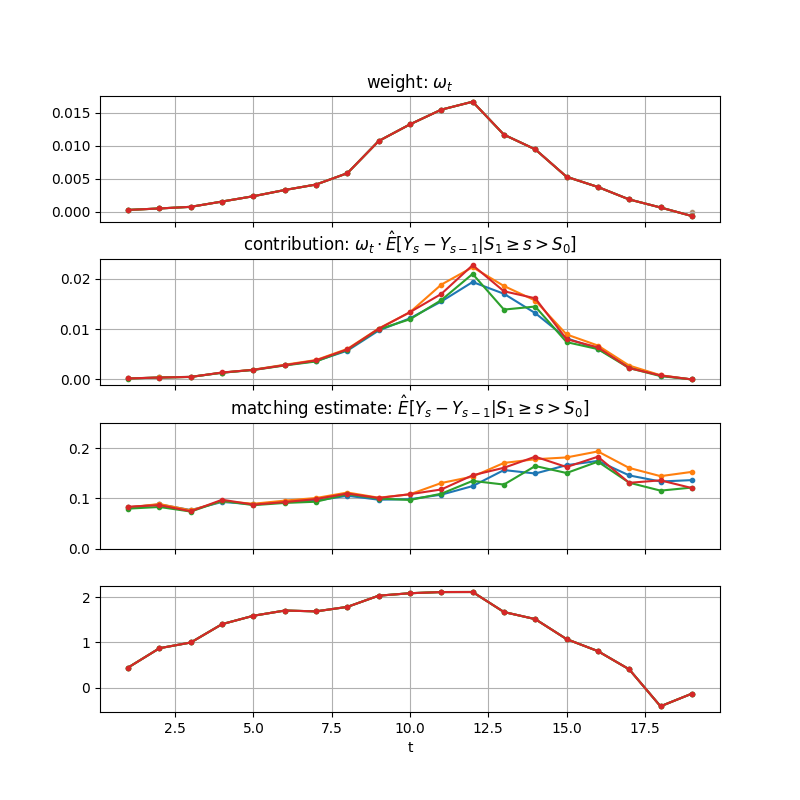

Fig. 2: QOB Data, Kappa shuffled


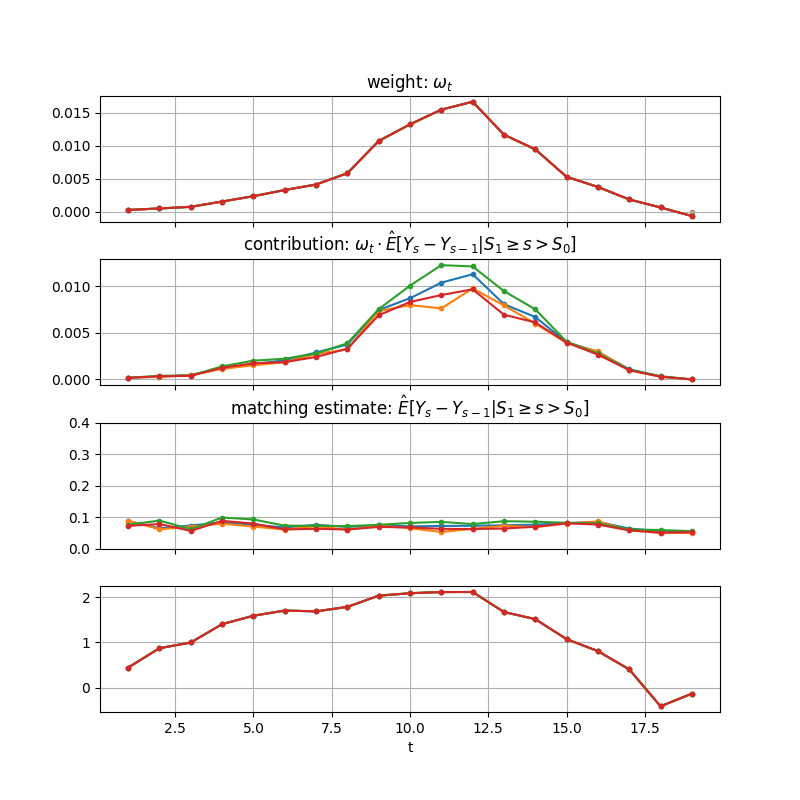

Fig. 3: Simulated Data, Kappa not shuffled


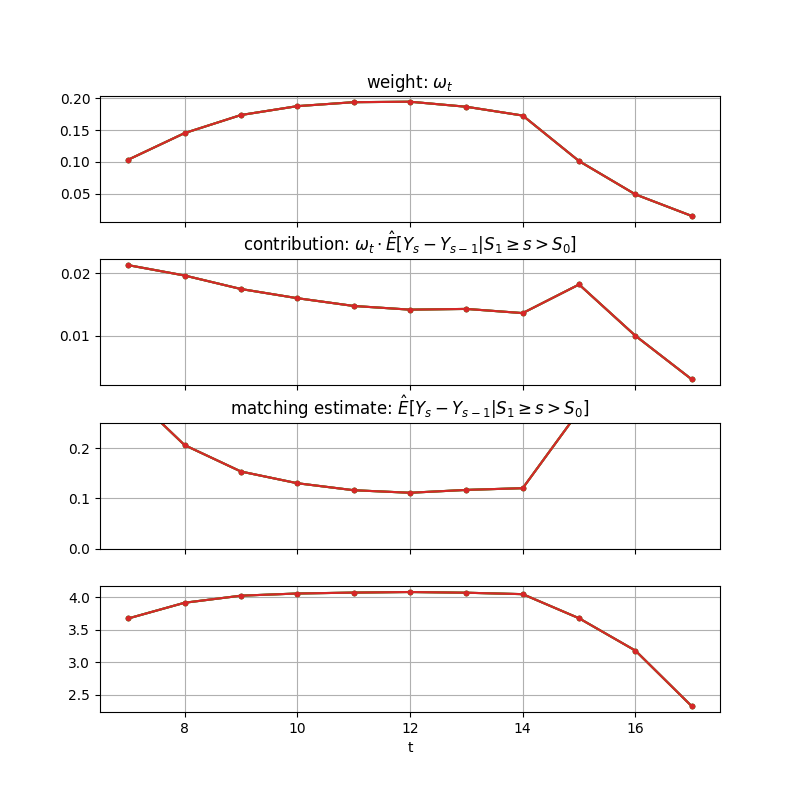

Fig. 4: SImulated Data, Kappa shuffled


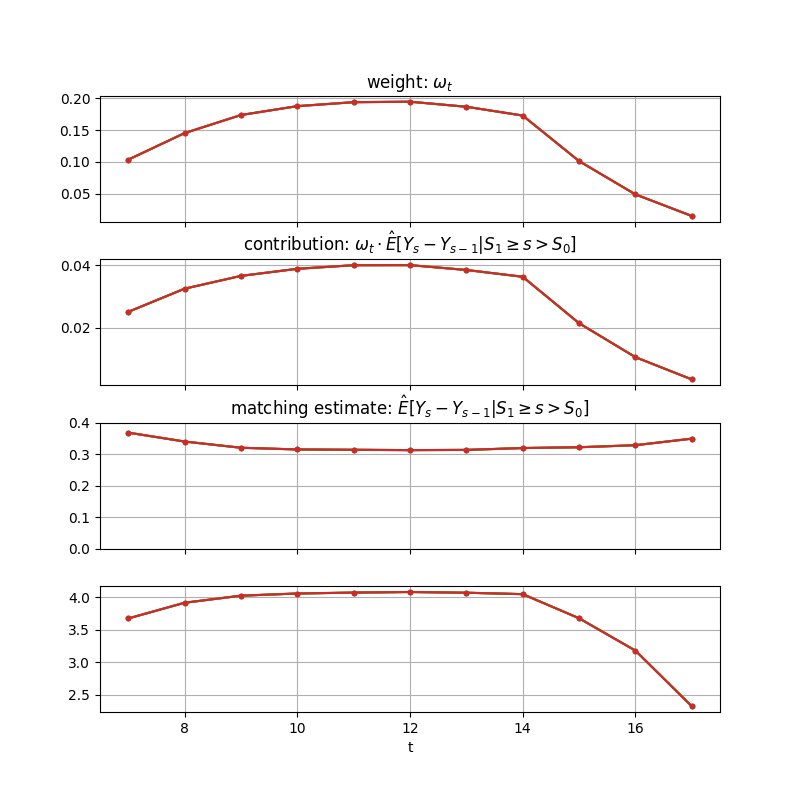

In [8]:
from IPython.display import Image, display
print("Fig. 1: QOB Data, Kappa not shuffled")
display(Image(filename='SIM_False_SHUFFLE_False.png'))

print("Fig. 2: QOB Data, Kappa shuffled")
display(Image(filename='SIM_False_SHUFFLE_True.png'))

print("Fig. 3: Simulated Data, Kappa not shuffled")
display(Image(filename='SIM_True_SHUFFLE_False.png'))

print("Fig. 4: SImulated Data, Kappa shuffled")
display(Image(filename='SIM_True_SHUFFLE_True.png'))

In [10]:
#(df_res[m_res]["omega"]*df_res[m_res]["alpha_0"]).sum()*1/df_res[m_res]["omega"].sum(),\
#(df_res[m_res]["omega"]*df_res[m_res]["alpha_1"]).sum()*1/df_res[m_res]["omega"].sum(),\
#(df_res[m_res]["omega"]*df_res[m_res]["alpha_2"]).sum()*1/df_res[m_res]["omega"].sum(),\
#(df_res[m_res]["omega"]*df_res[m_res]["alpha_3"]).sum()*1/df_res[m_res]["omega"].sum()


### Conclusions for QOB data

- QOB data:
    - The overall effect size is in a range of 12%-15% and hence comparable to the IV estimate (Fig. 1)

    - For the range up to $S=11$ the estimate is roughly equal to the IV estimate.

    - For all matching estimates there is a steady increase from around $S=11$ to a value around  15%.

    - This suggests that the effect is non constant over $S$. 

    - However, the computation of $\kappa_t$ seems subtle. It would require a much more careful analysis if this kind of analysis is prone to biases, contamination etc.

    - Yet, shuffled values of $\kappa_t$ (set PLT_SHUFFLE=True) yield flat curves below 10% and in the range of the OLS estimate. This suggests that $\kappa_t$ captures something here (Fig. 2).

- Simulated data:
    - The matching estimate is similar to the IV value (~15%), at least in the core region (S=10-14) (Fig. 3) 
    - In contrast,  shuffled data yields roughly constant curves with values close to the OLS value of
      30% (Fig. 4)
    - Again, this somehow suggests that this kind of estimate does indeed capture something about the data.